In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cbook import boxplot_stats
import scipy
from scipy import stats
import datetime
import numpy as np
import seaborn as sns

In [41]:
#API containing spending data on all practices in the 14L(Manchester) CCG
r = requests.get("https://openprescribing.net/api/1.0/spending_by_practice/?code=5.1&org=14L&format=json")

#API containing patient size of all practices in the Manchester CCG
r2 = requests.get("https://openprescribing.net/api/1.0/org_details/?org_type=practice&org=14L&keys=total_list_size&format=json")

print(r.status_code,r2.status_code)

200 200


In [42]:
#converting json files from API into dataframes
df1 = pd.DataFrame(r.json())
df2 = pd.DataFrame(r2.json())

#merging the 2 dataframes
df = pd.merge(df1, df2, how='inner')

#Normalising quantity per 1000 patients
quantity_n = pd.Series(df.quantity/(0.001*df.total_list_size))

#merging normalised quantity into whole dataframe
df = pd.merge(df, quantity_n.rename('quantity_n'), how='inner', left_index=True, right_index=True)
df.head()

,setting,quantity,items,actual_cost,ccg,date,row_id,row_name,total_list_size,quantity_n
0,4,18650,417,2856.64,14L,2014-10-01,P84004,FIVE OAKS FAMILIY PRACTICE,8819,2114.752239
1,4,8165,203,919.79,14L,2014-10-01,P84005,THE VALLANCE CENTRE,7223,1130.416724
2,4,17084,357,2063.74,14L,2014-10-01,P84009,AILSA CRAIG MEDICAL CENTRE,9342,1828.730465
3,4,17154,423,1873.21,14L,2014-10-01,P84010,THE BORCHARDT MEDICAL CENTRE,11108,1544.292402
4,4,28069,644,2992.22,14L,2014-10-01,P84012,NORTHENDEN GROUP PRACTICE,11028,2545.248458


In [43]:
#Shows datatypes of variables
print(df.info())
#df['date'] = pd.to_datetime(df['date'])
#df['row_name'] = df['row_name'].astype(str)

#shows if there are any null values in the dataframe
df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5409 entries, 0 to 5408
Data columns (total 10 columns):
setting            5409 non-null int64
quantity           5409 non-null int64
items              5409 non-null int64
actual_cost        5409 non-null float64
ccg                5409 non-null object
date               5409 non-null object
row_id             5409 non-null object
row_name           5409 non-null object
total_list_size    5409 non-null int64
quantity_n         5409 non-null float64
dtypes: float64(2), int64(4), object(4)
memory usage: 508.3+ KB
None


setting            0
quantity           0
items              0
actual_cost        0
ccg                0
date               0
row_id             0
row_name           0
total_list_size    0
quantity_n         0
dtype: int64

In [44]:
#Subsetting the data by timepoints or by practises using dictionaries
date={}
for i in df.date:
    date[i] = df[df.date == i]
prac={}
for i in df.row_name:
    prac[i] = df.row_name[df.row_name ==i]

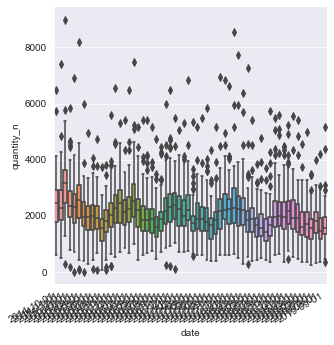

In [84]:
#boxplots of normalised quantity at each timepoint showing outliers
g = sns.catplot(x= 'date', y='quantity_n', data= df, kind = 'box')
g.fig.autofmt_xdate()

In [7]:
#extracting outliers for each time point using matplotlib.cbook's boxplot_stats, and putting it into a list
outliers = []
for i in date:
    outliers.append([y for stat in boxplot_stats(date[i]['quantity_n']) for y in stat['fliers']])

#Above creates a list of lists, this code will flatten this into a flat list
out = []
for sublist in outliers:
    for item in sublist:
        out.append(item)

#print(out, len(out))

In [15]:
#outdf = pd.DataFrame.from_records(outliers)
#outdf.head()

#makes new column which determines if the quantity_n value is an outlier
df['outlier'] = df['quantity_n'].isin(out)


In [54]:
#making a dataframe with outlier values removed
df1 = df[~df['quantity_n'].isin(out)]

#making a dataframe of the outliers
dfo = df[df['quantity_n'].isin(out)]

#print(df.shape, df1.shape, dfo.shape)

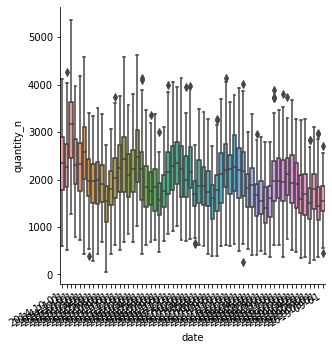

In [9]:
g = sns.catplot(x= 'date', y='quantity_n', data= df1, kind = 'box')
g.fig.autofmt_xdate()

In [145]:
#dfstats=df.groupby('date')['quantity_n'].describe().reset_index()
#dfstats.head()

#df1stats=df1.groupby('date')['quantity_n'].describe().reset_index()
#df1stats.head()

In [146]:
#plt.plot(dfstats['date'],dfstats['mean'], '-r', label='mean')
#plt.plot(dfstats['date'],dfstats['mean']+ 2*dfstats['std'], '--c')
#plt.plot(dfstats['date'],dfstats['mean']- 2*dfstats['std'], '--c')

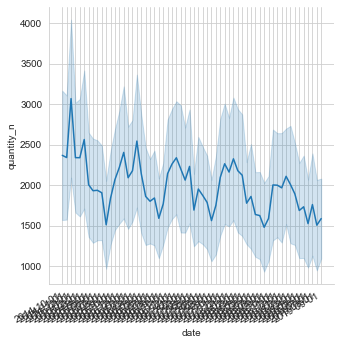

In [12]:
sns.set_style('darkgrid')
gmeans = sns.relplot(x='date', y='quantity_n', kind='line', ci='sd', data=df1)
gmeans.fig.autofmt_xdate()

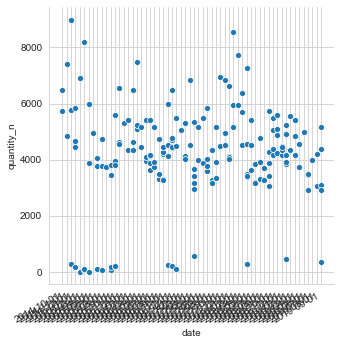

In [17]:
goutliers = sns.relplot(x='date', y='quantity_n', kind='scatter', ci='sd', data=dfo)
goutliers.fig.autofmt_xdate()

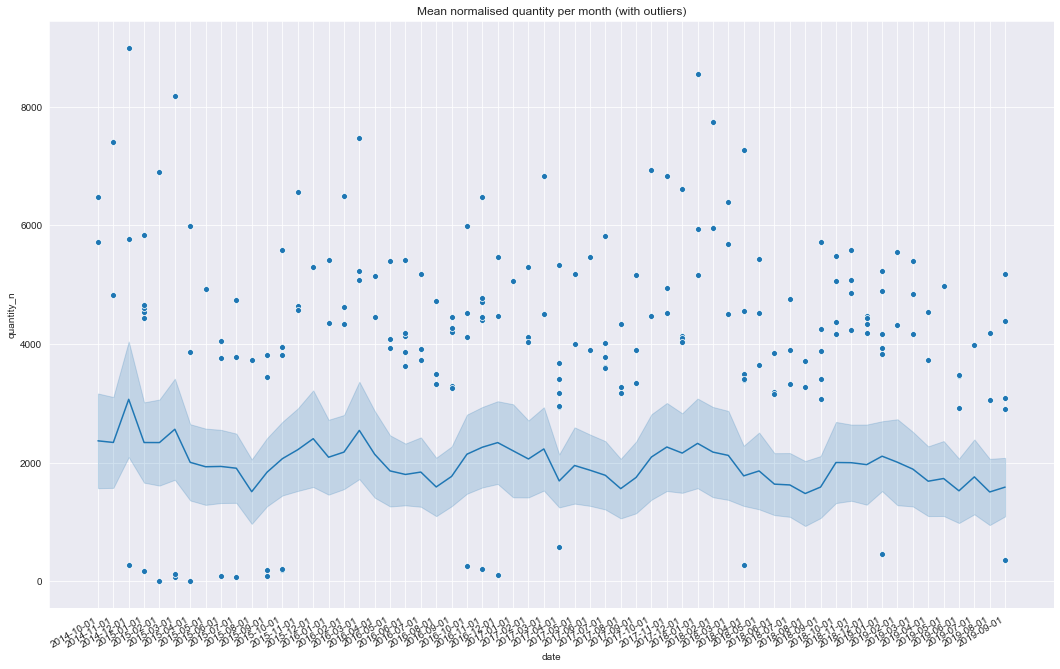

In [83]:
fig = plt.figure(figsize=(18,12))

sns.set_style('darkgrid')
sns.lineplot(x='date', y='quantity_n', ci='sd', data=df1),
sns.scatterplot(x='date', y='quantity_n', data=dfo)
plt.title('Mean normalised quantity per month (with outliers)')
fig.autofmt_xdate()